In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
data = pd.read_csv('data/data_cleaned.csv')

In [3]:
data.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,days_since_last_logon,inital_amount,EVENT_LABEL,ip_counts,Currency_eur,Currency_usd
0,3557.0,2196.0,62.0,4346.0,68.0,10447.0,legit,1,0,0
1,5454.0,3037.0,54.0,6215.0,67.0,6337.0,legit,1,0,0
2,4685.0,3415.0,43.0,6478.0,91.0,11032.0,legit,1,0,0
3,2934.0,2613.0,56.0,5475.0,21.0,13205.0,legit,1,0,0
4,4127.0,1364.0,62.0,2420.0,91.0,8346.0,legit,1,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       150000 non-null  float64
 1   transaction_amt        150000 non-null  float64
 2   transaction_adj_amt    150000 non-null  float64
 3   historic_velocity      150000 non-null  float64
 4   days_since_last_logon  150000 non-null  float64
 5   inital_amount          150000 non-null  float64
 6   EVENT_LABEL            150000 non-null  object 
 7   ip_counts              150000 non-null  int64  
 8   Currency_eur           150000 non-null  int64  
 9   Currency_usd           150000 non-null  int64  
dtypes: float64(6), int64(3), object(1)
memory usage: 11.4+ MB


In [5]:
#split dataset into features and target
#target is mapped to numeric (0 for fraud, 1 for legit)

X = data.drop('EVENT_LABEL', axis=1)
y = data['EVENT_LABEL'].map({'legit': 1, 'fraud': 0})

In [6]:
data.describe()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,days_since_last_logon,inital_amount,ip_counts,Currency_eur,Currency_usd
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,4642.444247,2521.478480,54.203040,4702.221347,49.866513,7998.028667,8.824667,0.029153,0.211787
std,1159.965133,604.262506,10.066597,1188.021280,29.191524,4045.344431,6.238538,0.168237,0.408576
min,1.000000,5.000000,1.000000,50.000000,0.000000,1000.000000,0.000000,0.000000,0.000000
25%,3821.000000,2104.000000,48.000000,3873.000000,25.000000,4491.000000,4.000000,0.000000,0.000000
50%,4666.000000,2544.000000,55.000000,4730.000000,50.000000,8002.000000,8.000000,0.000000,0.000000
75%,5475.000000,2951.000000,61.000000,5548.000000,75.000000,11491.000000,13.000000,0.000000,0.000000
max,9119.000000,4999.000000,99.000000,9999.000000,100.000000,15000.000000,37.000000,1.000000,1.000000


In [7]:
#split into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [8]:
#standardize features to have same range

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Modeling

In [9]:
#this is a classification problem
#try logistic regression, random forest / gradient boosting, and XG boost
#grid search CV on hyperparameters
#tree models: try both max_depth and min_samples_leaf hyperparameters
#neural network: grab templates online to use -- evaluate performance compared to trees (not as good for imbalanced dataset)

In [10]:
#import the models

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

In [11]:
#hyperparameter tuning for GB model

params = {'max_depth': [3, 10, 1000], 'min_samples_leaf': [1, 50, 100], 'n_iter_no_change': [5]}

clf = GridSearchCV(GradientBoostingClassifier(), params, cv=5)
clf.fit(X_train_scaled, y_train)
gb_params = clf.best_params_

In [12]:
#hyperparameter tuning for Random Forest model

params = {'max_depth': [3, 10, 15], 'min_samples_leaf': [1, 50, 100], 'n_estimators': [100]}

clf = GridSearchCV(RandomForestClassifier(), params, cv=5)
clf.fit(X_train_scaled, y_train)
rf_params = clf.best_params_

In [13]:
#hyperparameter tuning for XGBoost model

params = {'max_depth': [3, 6, 10], 'min_child_weight': [1, 50, 100], 'n_estimators': [100]}

clf = GridSearchCV(XGBClassifier(use_label_encoder=False), params, cv=5)
clf.fit(X_train_scaled, y_train, eval_metric='auc')
xgb_params = clf.best_params_

In [14]:
#create dictionary containing all of the models
#write a function that fits and predicts on all of the models in the dictionary and saves the 
#predicted values into a dataframe and the auc into a dictionary

from sklearn.metrics import roc_auc_score

models = {'rf': RandomForestClassifier(**rf_params), 
          'gbm': GradientBoostingClassifier(**gb_params),
          'lr': LogisticRegression(),
          'xgb': XGBClassifier(**xgb_params)}

predictions = pd.DataFrame()
pred_probas = pd.DataFrame()
auc_scores = {}

for name, model in models.items():
    local_model = model.fit(X_train_scaled, y_train)
    y_pred = local_model.predict(X_test_scaled)
    predictions[name] = y_pred
    y_pred_proba = local_model.predict_proba(X_test_scaled)
    pred_probas[name] = y_pred_proba[:,1]
    auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
    auc_scores[name] = auc_score

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:17:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [15]:
auc_scores

{'rf': 0.9255344466123283,
 'gbm': 0.9271985618703957,
 'lr': 0.9137989849808803,
 'xgb': 0.9288367998526357}

In [16]:
xgb_params

{'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}

In [17]:
#XGBoost model is the best performing with auc = 0.928 as an evaluation metric

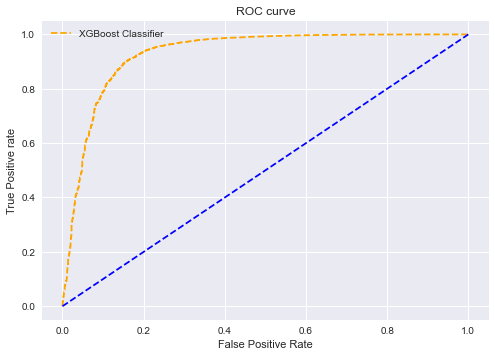

In [18]:
#find roc for xgb model

from sklearn.metrics import roc_curve

xgb_fpr, xgb_tpr, xgb_thresh = roc_curve(y_test, pred_probas['xgb'], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

#plot roc curve
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curve
plt.plot(xgb_fpr, xgb_tpr, linestyle='--',color='orange', label='XGBoost Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [20]:
#try neural network

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [22]:
# baseline model

model = Sequential()
model.add(Dense(9, input_dim=9,
                kernel_initializer='normal',
                activation="relu"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer='adam')

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=500)

Epoch 1/100
192/192 [==============================] - 1s 4ms/step - loss: 0.3896 - val_loss: 0.2305
Epoch 2/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1808 - val_loss: 0.1502
Epoch 3/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1364 - val_loss: 0.1278
Epoch 4/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1222 - val_loss: 0.1201
Epoch 5/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1168 - val_loss: 0.1170
Epoch 6/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1144 - val_loss: 0.1157
Epoch 7/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1131 - val_loss: 0.1149
Epoch 8/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1123 - val_loss: 0.1144
Epoch 9/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1117 - val_loss: 0.1139
Epoch 10/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1112 - val_lo

192/192 [==============================] - 0s 2ms/step - loss: 0.1052 - val_loss: 0.1079
Epoch 82/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1052 - val_loss: 0.1078
Epoch 83/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1052 - val_loss: 0.1078
Epoch 84/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1052 - val_loss: 0.1078
Epoch 85/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1052 - val_loss: 0.1078
Epoch 86/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1051 - val_loss: 0.1079
Epoch 87/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1051 - val_loss: 0.1079
Epoch 88/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1051 - val_loss: 0.1078
Epoch 89/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1051 - val_loss: 0.1077
Epoch 90/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1050 - val_loss: 

In [23]:
#predict probability and find AUC

y_pred_proba = model.predict(X_test_scaled)
y_pred_proba = y_pred_proba[:,0]

auc_score = roc_auc_score(y_test, y_pred_proba)
auc_score

0.9252793660476011

In [24]:
#smaller model

model = Sequential()
model.add(Dense(5, input_dim=9,
                kernel_initializer='normal',
                activation="relu"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer='adam')

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=500)

Epoch 1/100
192/192 [==============================] - 1s 2ms/step - loss: 0.5422 - val_loss: 0.4141
Epoch 2/100
192/192 [==============================] - 0s 2ms/step - loss: 0.3268 - val_loss: 0.2566
Epoch 3/100
192/192 [==============================] - 0s 2ms/step - loss: 0.2166 - val_loss: 0.1842
Epoch 4/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1657 - val_loss: 0.1502
Epoch 5/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1411 - val_loss: 0.1337
Epoch 6/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1285 - val_loss: 0.1254
Epoch 7/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1217 - val_loss: 0.1211
Epoch 8/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1179 - val_loss: 0.1187
Epoch 9/100
192/192 [==============================] - 1s 3ms/step - loss: 0.1158 - val_loss: 0.1174
Epoch 10/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1146 - val_lo

192/192 [==============================] - 0s 1ms/step - loss: 0.1070 - val_loss: 0.1102
Epoch 82/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1070 - val_loss: 0.1099
Epoch 83/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1070 - val_loss: 0.1100
Epoch 84/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1070 - val_loss: 0.1100
Epoch 85/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1070 - val_loss: 0.1100
Epoch 86/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1070 - val_loss: 0.1100
Epoch 87/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1070 - val_loss: 0.1100
Epoch 88/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1069 - val_loss: 0.1101
Epoch 89/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1070 - val_loss: 0.1101
Epoch 90/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1069 - val_loss: 

In [25]:
#predict probability and find AUC

y_pred_proba = model.predict(X_test_scaled)
y_pred_proba = y_pred_proba[:,0]

auc_score = roc_auc_score(y_test, y_pred_proba)
auc_score

0.92416768593908

In [26]:
#larger model

model = Sequential()
model.add(Dense(9, input_dim=9,
                kernel_initializer='normal',
                activation="relu"))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer='adam')

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=500)

Epoch 1/100
192/192 [==============================] - 1s 2ms/step - loss: 0.3552 - val_loss: 0.1725
Epoch 2/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1523 - val_loss: 0.1427
Epoch 3/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1373 - val_loss: 0.1339
Epoch 4/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1309 - val_loss: 0.1302
Epoch 5/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1276 - val_loss: 0.1278
Epoch 6/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1234 - val_loss: 0.1206
Epoch 7/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1153 - val_loss: 0.1139
Epoch 8/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1109 - val_loss: 0.1117
Epoch 9/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1091 - val_loss: 0.1106
Epoch 10/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1081 - val_lo

192/192 [==============================] - 0s 1ms/step - loss: 0.1031 - val_loss: 0.1062
Epoch 82/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1031 - val_loss: 0.1063
Epoch 83/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1032 - val_loss: 0.1070
Epoch 84/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1031 - val_loss: 0.1061
Epoch 85/100
192/192 [==============================] - 0s 1ms/step - loss: 0.1031 - val_loss: 0.1062
Epoch 86/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1030 - val_loss: 0.1062
Epoch 87/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1031 - val_loss: 0.1062
Epoch 88/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1030 - val_loss: 0.1065
Epoch 89/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1030 - val_loss: 0.1062
Epoch 90/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1030 - val_loss: 

In [27]:
#predict probability and find AUC

y_pred_proba = model.predict(X_test_scaled)
y_pred_proba = y_pred_proba[:,0]

auc_score = roc_auc_score(y_test, y_pred_proba)
auc_score

0.9289227843369957

In [28]:
name = 'nn'
predictions[name] = np.where(y_pred_proba > 0.5, 1, 0)
pred_probas[name] = y_pred_proba
auc_scores[name] = auc_score

In [29]:
#neural network with 1 hidden layer performs the best, with auc=0.929

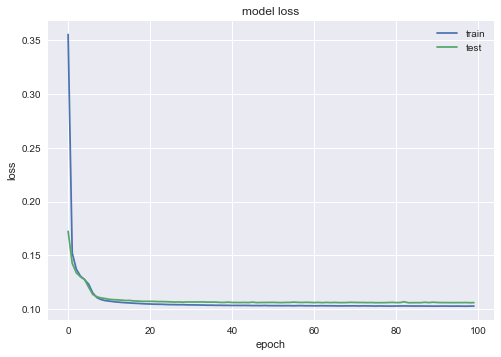

In [30]:
#plot the loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

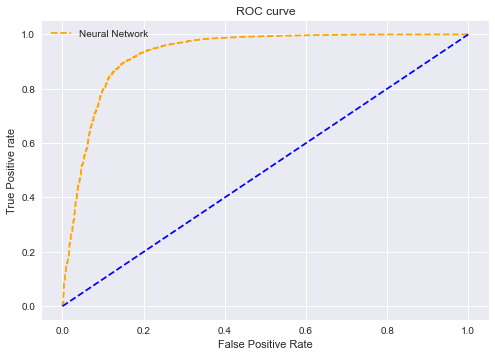

In [31]:
#plot roc curve

nn_fpr, nn_tpr, nn_thresh = roc_curve(y_test, pred_probas['nn'], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

#plot roc curve
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curve
plt.plot(nn_fpr, nn_tpr, linestyle='--',color='orange', label='Neural Network')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

In [33]:
#baseline model - xgboost with a max depth of 2 (stub) vs random forest (many unrelated trees) max depth of 2, 1000 trees

model = RandomForestClassifier(max_depth=2, n_estimators=1000)
model_fit = model.fit(X_train_scaled, y_train)
y_pred = model_fit.predict(X_test_scaled)
y_pred_proba = model_fit.predict_proba(X_test_scaled)
auc_score = roc_auc_score(y_test, y_pred_proba[:,1])

In [34]:
name = 'base'
predictions[name] = y_pred
pred_probas[name] = y_pred_proba[:,1]
auc_scores[name] = auc_score

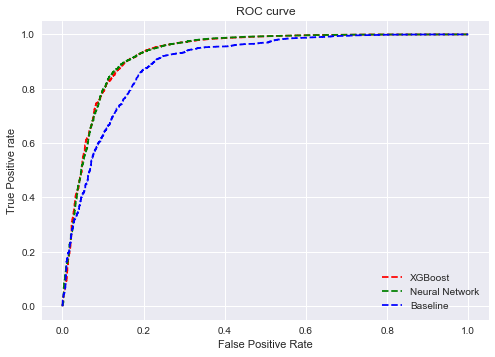

In [35]:
#plot roc curves of all 3 models

base_fpr, base_tpr, base_thresh = roc_curve(y_test, pred_probas['base'], pos_label=1)

# plot roc curve
plt.plot(xgb_fpr, xgb_tpr, linestyle='--',color='red', label='XGBoost')
plt.plot(nn_fpr, nn_tpr, linestyle='--',color='green', label='Neural Network')
plt.plot(base_fpr, base_tpr, linestyle='--',color='blue', label='Baseline')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

In [36]:
auc_scores

{'rf': 0.9255344466123283,
 'gbm': 0.9271985618703957,
 'lr': 0.9137989849808803,
 'xgb': 0.9288367998526357,
 'nn': 0.9289227843369957,
 'base': 0.8947436272739336}

In [37]:
#calculate monetary impact from each model (Baseline vs XGBoost and Neural Network) and determine threshold
#that minimizes cost and maximizes approval rate
#baseline model = 85% recall

In [69]:
#find precision recall values for all thresholds for baseline model

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, pred_probas['base'])
base_pred = pd.DataFrame()
base_pred['precision'] = precision
base_pred['recall'] = recall
base_pred.drop(base_pred.count()-1, inplace=True)
base_pred['thresholds'] = thresholds

base_pred.sort_values(by=['thresholds'], ascending=False, inplace=True)

In [70]:
#baseline model - set recall to 0.85, calculate approval rate and chargebacks
#find threshold where recall = 0.85

base_pred[base_pred.recall >= 0.85].head(1)

,precision,recall,thresholds
5113,0.987218,0.850222,0.944706


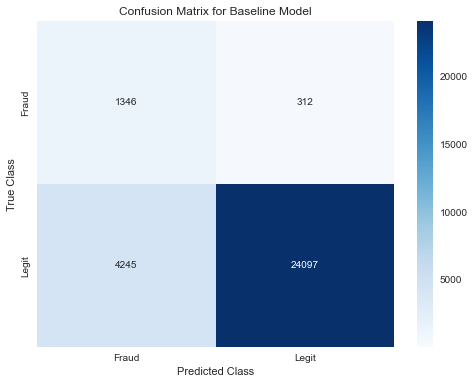

In [91]:
#print confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, np.where(pred_probas['base'] >= 0.944706, 1, 0))
labels = ['Fraud', 'Legit']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix for Baseline Model')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [72]:
#approval rate is (24097+312)/30000 = 81.36%
#chargebacks = false positive rate
#with baseline model, we get a chargeback rate of 312/30000 = 1.04%
#revenue = approved volume - chargebacks
#revenue = 24097/30000 * volume = 80.32% * volume
#missed revenue = false negative rate
#missed revenue = 4245/30000 = 14.15%

In [92]:
model_compare = pd.DataFrame()

model_compare['Metric'] = ['Order Volume', 'Approval Rate', 'Approved Volume', 'Chargeback Rate', 'Chargeback Volume', 'Revenue', 'Missed Revenue']
model_compare['Baseline'] = [X_test.transaction_amt.sum(), '81.36%', round(X_test.transaction_amt.sum()*0.8136, 2), '1.04%', round(X_test.transaction_amt.sum()*0.0104, 2), round(X_test.transaction_amt.sum()*0.8032, 2), round(X_test.transaction_amt.sum()*0.1415, 2)]

In [74]:
#find precision recall values for all thresholds for XGBoost model

precision, recall, thresholds = precision_recall_curve(y_test, pred_probas['xgb'])
xgb_pred = pd.DataFrame()
xgb_pred['precision'] = precision
xgb_pred['recall'] = recall
xgb_pred.drop(xgb_pred.count()-1, inplace=True)
xgb_pred['thresholds'] = thresholds

xgb_pred.sort_values(by=['thresholds'], ascending=False, inplace=True)

In [75]:
#find threshold where recall = 0.85 and compare precision

xgb_pred[xgb_pred.recall >= 0.85].head(1)

,precision,recall,thresholds
5687,0.991358,0.850011,0.964036


In [76]:
#increase recall to 0.9

xgb_pred[xgb_pred.recall >= 0.9].head(1)

,precision,recall,thresholds
4226,0.98991,0.900007,0.941767


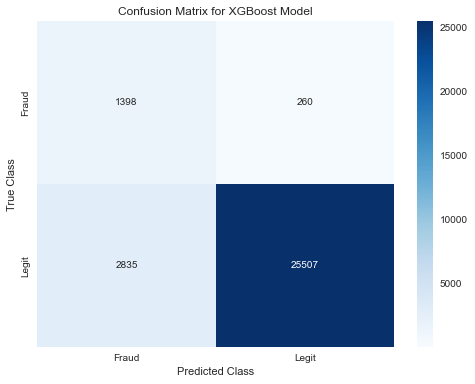

In [90]:
#print confusion matrix

cm = confusion_matrix(y_test, np.where(pred_probas['xgb'] >= 0.941767, 1, 0))
labels = ['Fraud', 'Legit']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix for XGBoost Model')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [93]:
#approval rate is (25507+260)/30000 = 85.89%
#chargeback rate is 260/30000 = 0.867%
#revenue is 25507/30000 * volume = 85.02% * volume
#missed revenue is 2835/30000 = 9.45%
#add to comparison dataframe

model_compare['XGBoost'] = [X_test.transaction_amt.sum(), '85.89%', round(X_test.transaction_amt.sum()*0.8589, 2), '0.867%', round(X_test.transaction_amt.sum()*0.00867, 2), round(X_test.transaction_amt.sum()*0.8502, 2), round(X_test.transaction_amt.sum()*0.0945, 2)]

In [79]:
#find precision recall values for all thresholds for Neural Network model

precision, recall, thresholds = precision_recall_curve(y_test, pred_probas['nn'])
nn_pred = pd.DataFrame()
nn_pred['precision'] = precision
nn_pred['recall'] = recall
nn_pred.drop(nn_pred.count()-1, inplace=True)
nn_pred['thresholds'] = thresholds

nn_pred.sort_values(by=['thresholds'], ascending=False, inplace=True)

In [80]:
#find threshold where recall = 0.85 and compare precision

nn_pred[nn_pred.recall >= 0.85].head(1)

,precision,recall,thresholds
5704,0.991889,0.850011,0.969887


In [81]:
#increase recall to 0.901

nn_pred[nn_pred.recall >= 0.901].head(1)

,precision,recall,thresholds
4201,0.990036,0.90103,0.945988


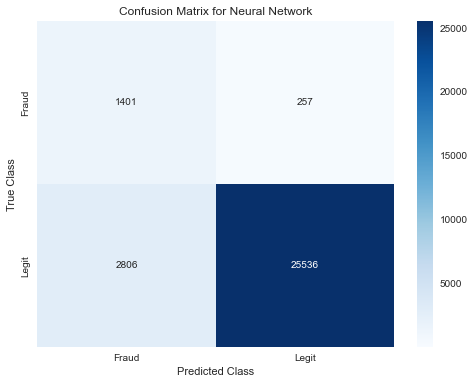

In [89]:
#print confusion matrix

cm = confusion_matrix(y_test, np.where(pred_probas['nn'] >= 0.945988, 1, 0))
labels = ['Fraud', 'Legit']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix for Neural Network')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [94]:
#approval rate is (25536+257)/30000 = 85.98%
#chargeback rate at recall = 0.901 is 257/30000 = 0.857%
#revenue is 25536/30000 * volume = 85.12% * volume
#missed revenue is 2806/30000 = 9.35%
#add to comparison dataframe

model_compare['Neural Network'] = [X_test.transaction_amt.sum(), '85.98%', round(X_test.transaction_amt.sum()*0.8598, 2), '0.857%', round(X_test.transaction_amt.sum()*0.00857, 2), round(X_test.transaction_amt.sum()*0.8512, 2), round(X_test.transaction_amt.sum()*0.0935, 2)]

In [95]:
model_compare.set_index('Metric')

,Baseline,XGBoost,Neural Network
Metric,,,
Order Volume,75959876.0,75959876.0,75959876.0
Approval Rate,81.36%,85.89%,85.98%
Approved Volume,61800955.11,65241937.5,65310301.38
Chargeback Rate,1.04%,0.867%,0.857%
Chargeback Volume,789982.71,658572.12,650976.14
Revenue,61010972.4,64581086.58,64657046.45
Missed Revenue,10748322.45,7178208.28,7102248.41
